In [1]:
import pandas as pd
import numpy as np

target_countries = ['Senegal', 'Mauritania', 'Mali', 'Burkina Faso', 'Niger', 'Nigeria', 'Cameroon', 'Chad', 'Central African Republic', 'South Sudan', 'Sudan', 'Eritrea']

dataset = pd.read_csv('datasets/DatasetMonthly.csv')

dataset.head()

,COUNTRY,MY,FATALITIES,Demonstrations,Political violence,Political violence; Demonstrations,Strategic developments,Population,Voice and Accountability: Estimate,Regulatory Quality: Estimate,Rule of Law: Estimate,Control of Corruption: Estimate,Political Stability and Absence of Violence/Terrorism: Estimate,Population density,Population growth (annual %)
0,Burkina Faso,1998-01,0,0,0,0,0,7.049259,-0.396195,-0.230121,-0.912859,0.09559,-0.112211,40.939558,2.748877
1,Burkina Faso,1998-02,0,0,0,0,0,7.049259,-0.396195,-0.230121,-0.912859,0.09559,-0.112211,40.939558,2.748877
2,Burkina Faso,1998-03,0,0,0,0,0,7.049259,-0.396195,-0.230121,-0.912859,0.09559,-0.112211,40.939558,2.748877
3,Burkina Faso,1998-04,0,0,0,0,0,7.049259,-0.396195,-0.230121,-0.912859,0.09559,-0.112211,40.939558,2.748877
4,Burkina Faso,1998-05,0,0,0,0,0,7.049259,-0.396195,-0.230121,-0.912859,0.09559,-0.112211,40.939558,2.748877


c:\Users\cotol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cotol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cotol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cotol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

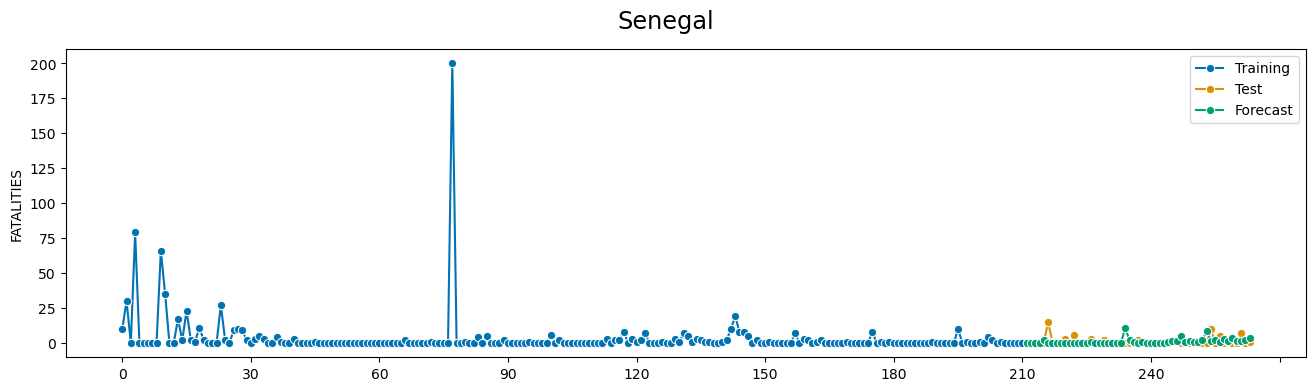

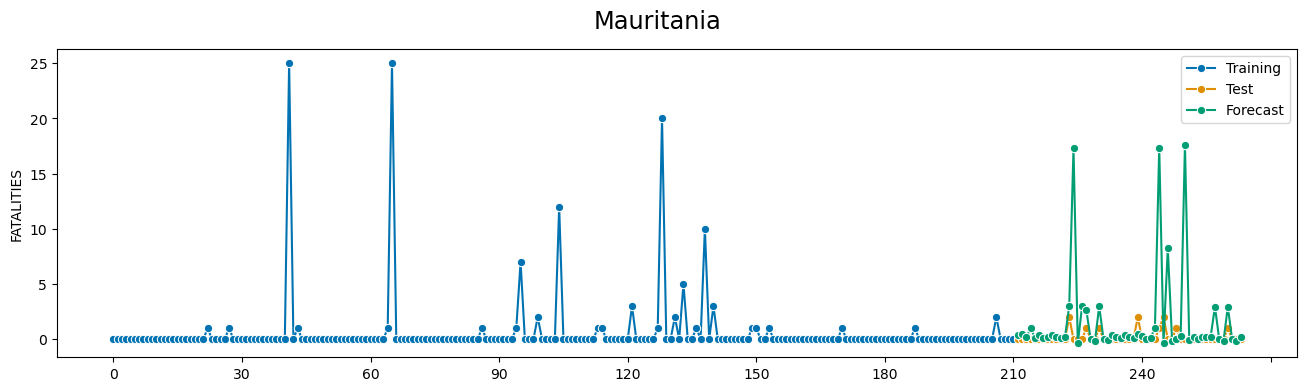

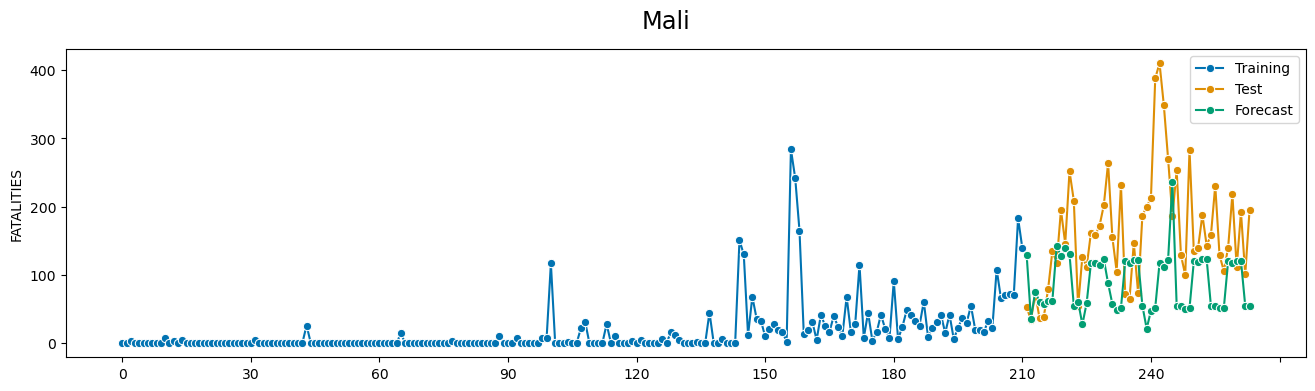

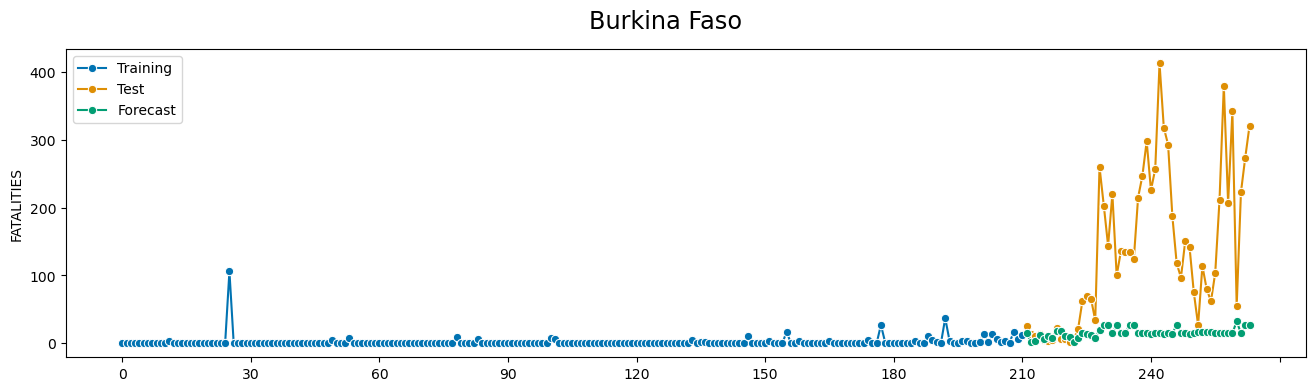

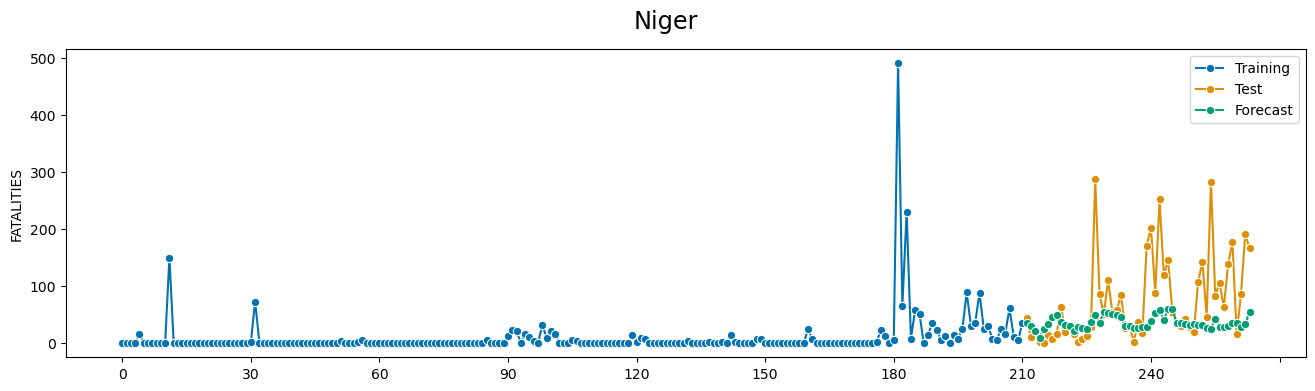

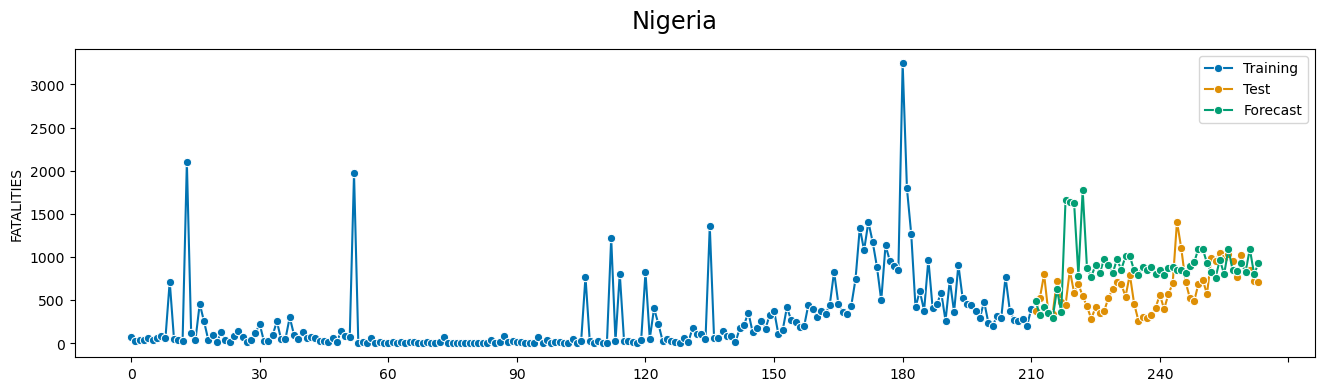

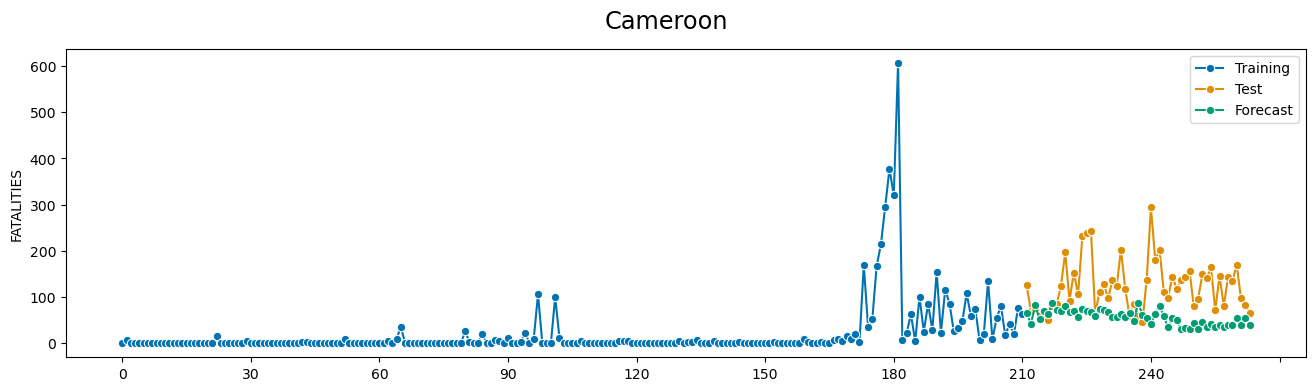

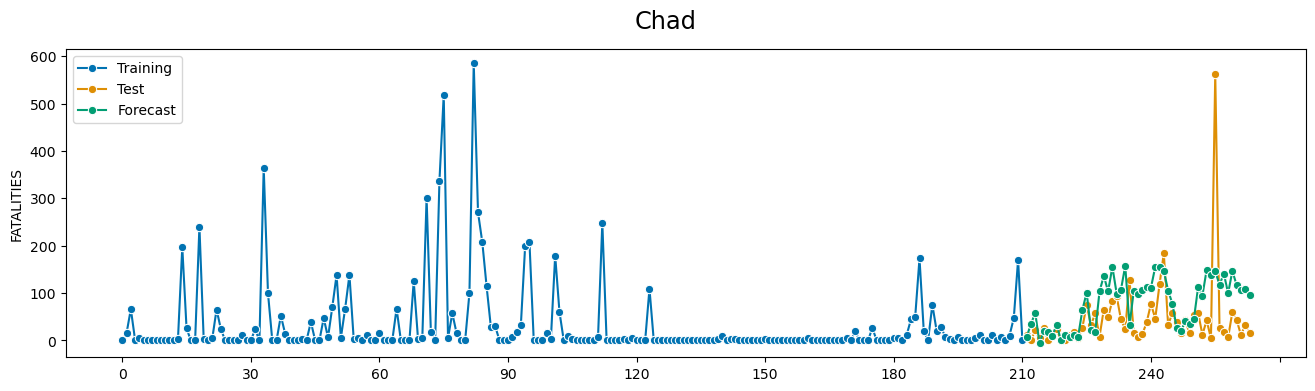

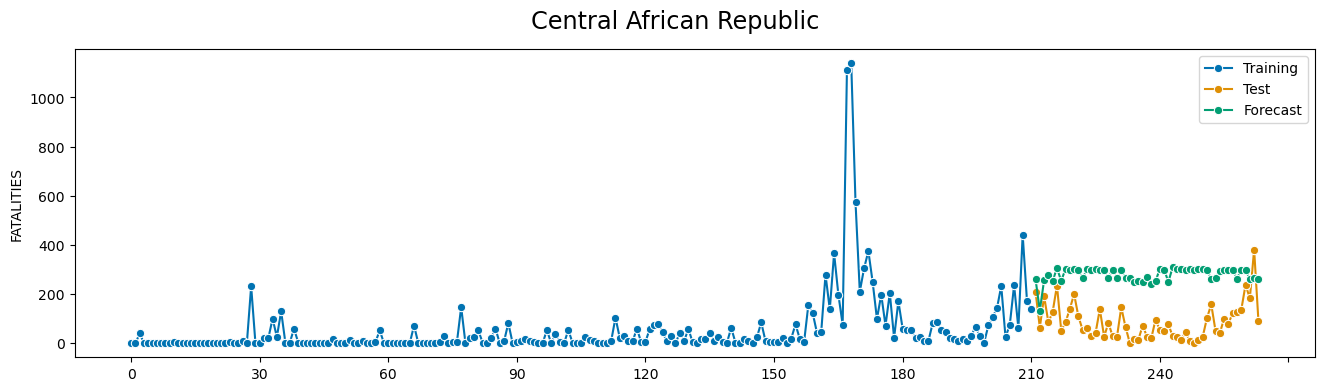

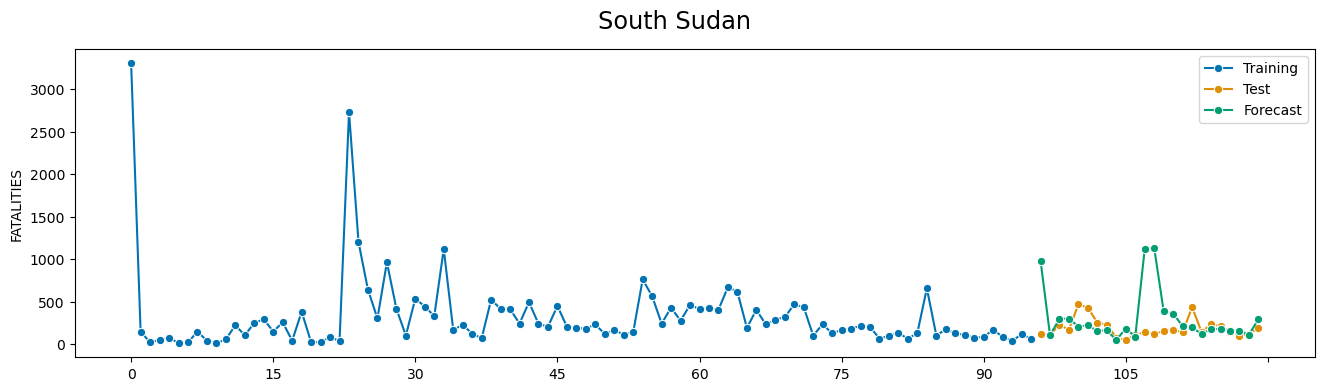

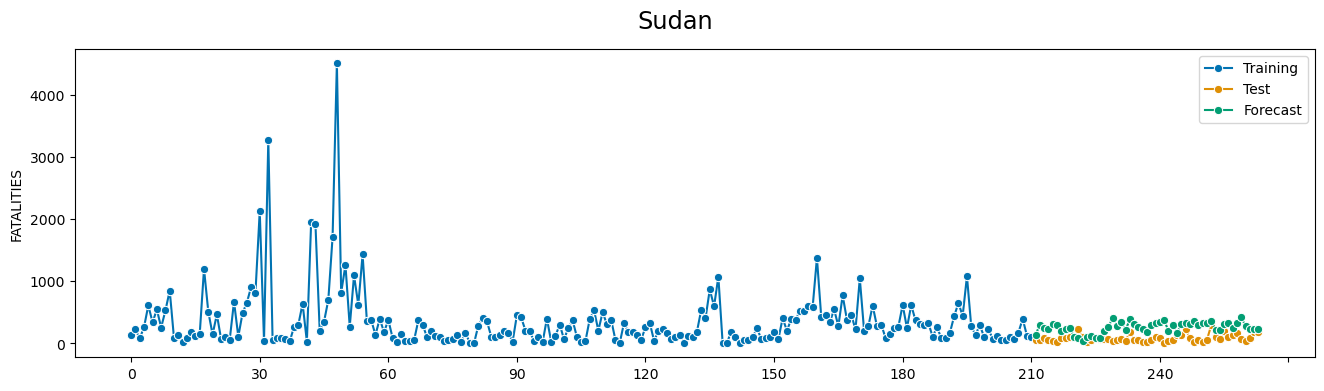

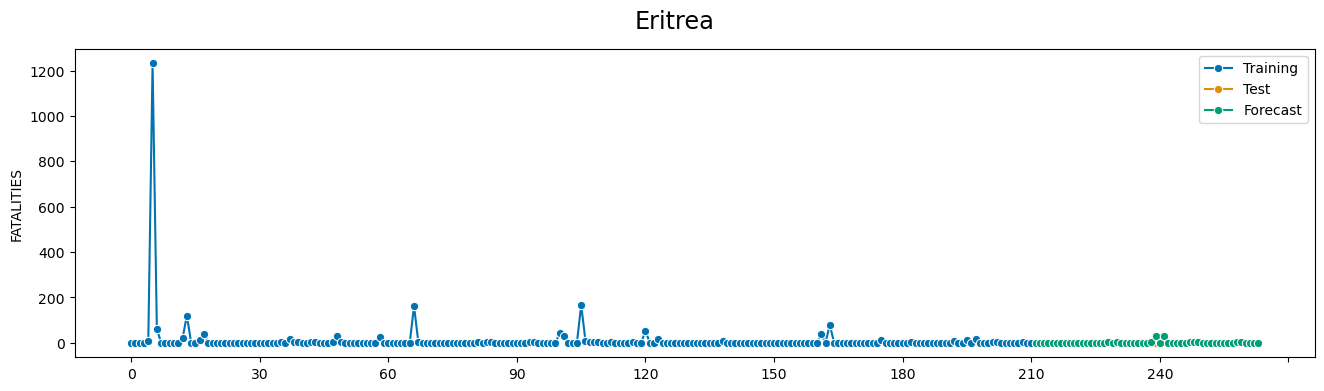

In [3]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import SingleWindowSplitter, ForecastingRandomizedSearchCV, temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sktime.forecasting.base import ForecastingHorizon
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from sktime.utils import plot_series


def create_forecaster():
    
    regressor = xgb.XGBRegressor()
    forecaster = make_reduction(regressor, window_length=6, strategy='recursive', windows_identical=False)

    return forecaster



country_list = dataset['COUNTRY'].unique()
results = []

for cid, country in enumerate(target_countries):
    data = dataset.loc[dataset['COUNTRY'] == country].copy()
    data = data.drop('COUNTRY', axis = 1)
    data = data.drop('MY', axis=1)
    data = data.reset_index(drop=True)
    
    ytrain, ytest = temporal_train_test_split(data['FATALITIES'], test_size=0.20)
    xtrain, xtest = temporal_train_test_split(data.loc[:, data.columns != 'FATALITIES'], test_size=0.20)
    
    forecaster = create_forecaster()
    forecaster.fit(ytrain, xtrain)

    # # Make forecasts for the test set
    fh = ForecastingHorizon(ytest.index, is_relative = False)
    y_pred = forecaster.predict(fh, xtest)
    
    # Plot the actual vs. predicted delays
    
    plot_series(ytrain, ytest, y_pred, labels=["Training", "Test", "Forecast"], title=country)
    results.append((mean_absolute_error(ytest, y_pred), mean_absolute_percentage_error(ytest, y_pred)))
    

In [4]:
print(results)

[(1.9795519000024728, 4338706905973663.5), (1.6130756154724502, 4908542123746362.0), (88.04562665831368, 0.49865895065683324), (122.73707963160749, 0.8988374699805175), (50.18001999045318, 2171499646451094.8), (340.7322174648069, 0.6903662552456741), (71.14419573657918, 0.5089771399314058), (57.81458505706967, 5396437717557714.0), (197.1037655236586, 15.883093840220909), (204.72807582219443, 1.4316632096074127), (175.49451093853645, 3.971105879373063), (1.7877400405704975, 5476897857445733.0)]
